In [ ]:
realwaste_dataset_path = "/Code/Datasets/realwaste-main/RealWaste"

In [1]:
import sys
import wget
import requests
import os
from PIL import Image, ImageDraw
from IPython.display import display
import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import time
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sys.path.append('../../mae')
import models_mae
from models_mae import MaskedAutoencoderViT
from functools import partial
from sklearn.metrics import accuracy_score, recall_score, precision_score
%matplotlib inline


In [2]:
from glob import glob
import os
import PIL.Image
import math
from torchvision.transforms.functional import pil_to_tensor


labels = ["Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash", "Paper", "Plastic", "Textile Trash", "Vegetation"]

def load_realwaste(path, sample_per_label = 300, training_percent = 0.8):
    if not os.path.isdir(path):
        raise Exception(f"{path} path does not exist")
    
    label_dict = {}

    for label in labels:
        label_dict[label] = []
        for file in glob(os.path.join(path, label, "*.jpg")):
            label_dict[label].append(PIL.Image.open(file))
    
    train_ds = []
    eval_ds = []
    train_count = math.floor(sample_per_label * training_percent)
    test_count = sample_per_label - train_count

    for label in labels:
        for i in range(train_count):
            if i < len(label_dict[label]):
                train_ds.append({"image": label_dict[label][i], "label": label, "y": labels.index(label)})
            else:
                print(f"Only {i} train samples for {label}")
                break

        for i in range(train_count, train_count + test_count):
            if i < len(label_dict[label]):
                eval_ds.append({"image": label_dict[label][i], "label": label, "y": labels.index(label)})
            else:
                print(f"Only {i} eval samples for {label}")
                break

    return pd.DataFrame(train_ds), pd.DataFrame(eval_ds)

train_df, eval_df = load_realwaste(realwaste_dataset_path)
display(train_df)
display(eval_df)

,image,label,y
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Cardboard,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Cardboard,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Cardboard,0
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Cardboard,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Cardboard,0
...,...,...,...
2155,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Vegetation,8
2156,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Vegetation,8
2157,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Vegetation,8
2158,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Vegetation,8


,image,label,y
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Cardboard,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Cardboard,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Cardboard,0
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Cardboard,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Cardboard,0
...,...,...,...
535,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Vegetation,8
536,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Vegetation,8
537,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Vegetation,8
538,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Vegetation,8


In [3]:
class RealWasteDataset(Dataset):
    def __init__(self, df):
        super().__init__()

        self.df = df

        self.y = df.iloc[:, 2]

        df = df.apply(lambda row: pil_to_tensor(row["image"]), axis=1)
        self.x = torch.stack(df.tolist(), dim=0)
        
        self.x = torch.tensor(self.x, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long)

        self.x /= 255.0
        self.x = F.interpolate(self.x, size=(224, 224), mode='bilinear', antialias=True)
        print(self.y.shape)
        print(self.x.shape)
        
    def shape(self):
        return self.x.shape

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

eval_ds = RealWasteDataset(eval_df)
train_ds = RealWasteDataset(train_df)

/tmp/ipykernel_12955/4270381144.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


torch.Size([540])
torch.Size([540, 3, 224, 224])
torch.Size([2160])
torch.Size([2160, 3, 224, 224])


array([[<Axes: title={'center': 'y'}>]], dtype=object)

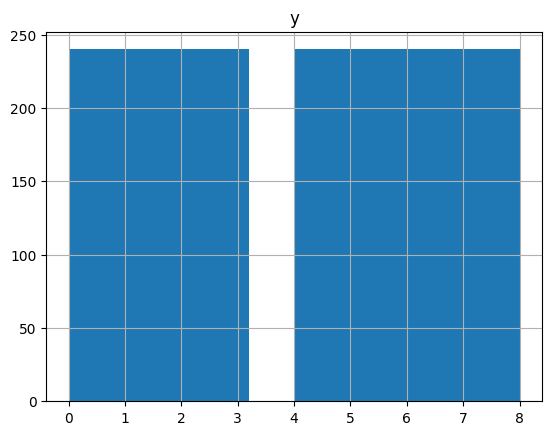

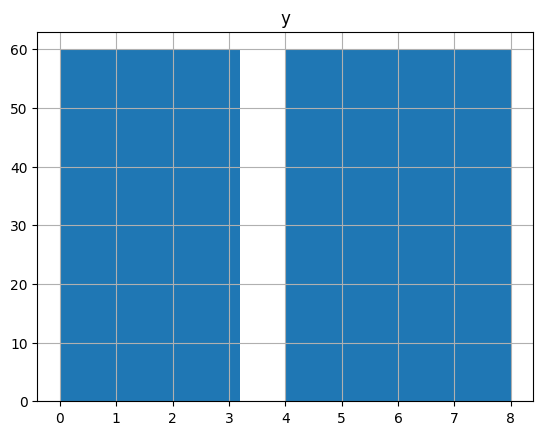

In [4]:
train_df.hist(column = 'y')
eval_df.hist(column = 'y')

In [5]:
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True)
test_loader = DataLoader(eval_ds, batch_size=10, shuffle=False)

/tmp/ipykernel_12955/4270381144.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


torch.Size([9])
torch.Size([9, 3, 224, 224])
torch.Size([9, 3, 224, 224])
    Cardboard      Food Organics      Glass      Metal      Miscellaneous Trash      Paper      Plastic      Textile Trash      Vegetation


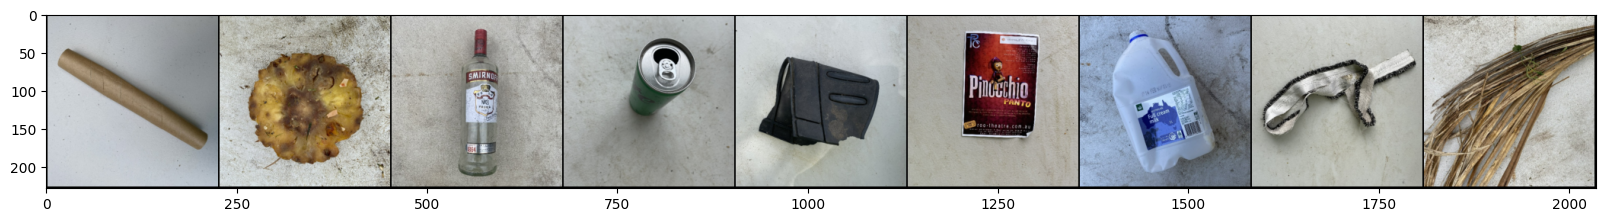

In [6]:
first_df = train_df.groupby('label', as_index=False).first()
first_dataset = RealWasteDataset(first_df)

images, l = first_dataset[:]
print(images.shape)

im = make_grid(images, nrow=len(first_df))
plt.figure(figsize=(20,8))
plt.imshow(np.transpose(im.numpy(),(1, 2, 0)))

labels_string = "      ".join(labels)
print("    " + labels_string)

In [7]:
# Defining the network architecture

class RealWasteModel(nn.Module):
    
    def __init__(self):       
        super().__init__()
        chkpt_dir = 'mae_visualize_vit_large.pth'
        model_mae = self.prepare_model(chkpt_dir)
        print('Model loaded.')
        
        self.backbone_model = model_mae      
        self.backbone_model.cuda()

        self.fc1 = nn.Linear(in_features=1024, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=len(labels))

    def forward(self, X):

        X = self.forward_ecoder(X, self.backbone_model)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        return F.log_softmax(input=self.fc3(X), dim=1)  
    
    def prepare_model(self, chkpt_dir):
        # build model
        model = MaskedAutoencoderViT(
            patch_size=16, img_size=224, embed_dim=1024, depth=24, num_heads=16,
            decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
            mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))
        
        # load model
        checkpoint = torch.load(chkpt_dir, map_location='cuda')
        msg = model.load_state_dict(checkpoint['model'], strict=False)
        print(msg)
        for p in model.parameters():
            p.requires_grad = False 

        print(type(model))
        return model


    def forward_ecoder(self, x, model):
        # run MAE
        emb, mask, id = model.forward_encoder(x.float(), mask_ratio=0.75)
        return emb[:, 0, :]

In [19]:
# Training the model
epochs = 20

writer = SummaryWriter('RealWasteLog')

model = RealWasteModel()
model = model.cuda()

start_time = time.time()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
accuracy_graph = []
precision_graph = []
recall_graph = [] 

for i in range(epochs):
    tst_corr = 0
    trn_corr = 0


    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%28 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/{len(train_df)}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    
    writer.add_scalar("Loss/train", loss, i)     
    train_losses.append(loss.cpu().detach().numpy())

    # Test model per epoch
    model.eval()
    y_true_label = []
    predictions = []
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

            y_true_label.extend(y_test.cpu().detach().numpy())
            predictions.extend(predicted.cpu().detach().numpy())
    
    accuracy = accuracy_score(y_true_label, predictions)
    precision = precision_score(y_true_label, predictions, average="macro")
    recall = recall_score(y_true_label, predictions, average="macro")

    accuracy_graph.append(accuracy)
    precision_graph.append(precision)
    recall_graph.append(recall)

    writer.add_scalar("accuracy/test", tst_corr, i)
    model.train()

    loss = criterion(y_val,y_test)
    test_losses.append(loss.cpu().detach().numpy())
    print(f'test accuracy: {accuracy*100:7.2f}, precision: {precision*100:7.2f}, recall: {recall*100:7.2f}')
    torch.save(model.state_dict(), f"RealWasteEpoch/RealWasteModel_Epoch_{i}.pt")
    
total_time = time.time() - start_time
print(f'\nDuration: {total_time:.0f} seconds')

<All keys matched successfully>
<class 'models_mae.MaskedAutoencoderViT'>
Model loaded.
epoch:  0  batch:   28 [   280/2160]  loss: 2.18128443  accuracy:  18.929%
epoch:  0  batch:   56 [   560/2160]  loss: 2.02781272  accuracy:  23.036%
epoch:  0  batch:   84 [   840/2160]  loss: 1.71460366  accuracy:  26.071%
epoch:  0  batch:  112 [  1120/2160]  loss: 1.54064441  accuracy:  28.214%
epoch:  0  batch:  140 [  1400/2160]  loss: 1.35177302  accuracy:  30.714%
epoch:  0  batch:  168 [  1680/2160]  loss: 0.66576844  accuracy:  32.619%
epoch:  0  batch:  196 [  1960/2160]  loss: 0.67377245  accuracy:  35.765%
test accuracy:   44.81, precision:   42.30, recall:   44.81
epoch:  1  batch:   28 [   280/2160]  loss: 1.27971447  accuracy:  57.143%
epoch:  1  batch:   56 [   560/2160]  loss: 0.79069567  accuracy:  59.464%
epoch:  1  batch:   84 [   840/2160]  loss: 1.33585966  accuracy:  58.333%
epoch:  1  batch:  112 [  1120/2160]  loss: 1.23728836  accuracy:  59.018%
epoch:  1  batch:  140 [  1

In [9]:
#model.load_state_dict(torch.load("SignLanguageModel_Epoch_18.pt"))
#model.eval()

test_load_all = DataLoader(eval_ds, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for b, (X_test, y_test) in enumerate(test_load_all):
        y_val = model(X_test.cuda())
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test.cuda()).sum()
print(f'Test Accuracy: {correct.item()/len(eval_df)*100:.2f}%')
predicted = predicted.cpu()

Test Accuracy: 71.67%


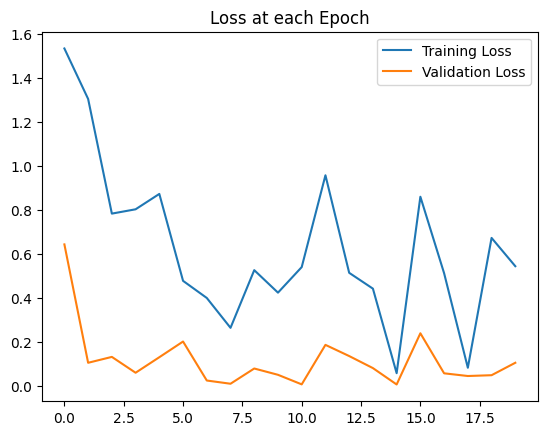

In [10]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss at each Epoch')
plt.legend()

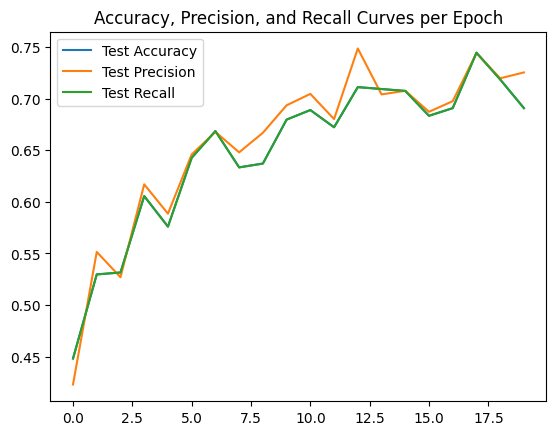

In [20]:
plt.plot(accuracy_graph, label="Test Accuracy")
plt.plot(precision_graph, label="Test Precision")
plt.plot(recall_graph, label="Test Recall")
plt.title('Accuracy, Precision, and Recall Curves per Epoch')
plt.legend()



['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
tensor([0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 1, 1, 1, 1, 4, 1, 1, 1, 8, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 4, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 8, 1, 8, 1, 8, 8, 1, 1, 1, 1, 1, 1, 8, 1, 1, 8, 1, 1, 1, 1,
        2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 0, 4, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 6, 2, 2, 2, 2, 3, 2, 2, 2, 2,
        2, 2, 0, 3, 2, 0, 0, 3, 2, 0, 2, 0, 3, 3, 0, 6, 6, 3, 1, 6, 3, 3, 1, 1,
        1, 3, 3, 3, 3, 0, 3, 0, 5, 3, 5, 3, 5, 6, 6, 3, 3, 3, 2, 2, 0, 0, 3, 4,
        4, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 5, 3, 3, 3, 6, 3, 3, 3, 3, 5, 3, 3, 5,
        4, 6, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 7, 4, 4, 3, 4, 4, 4, 4, 4, 4, 

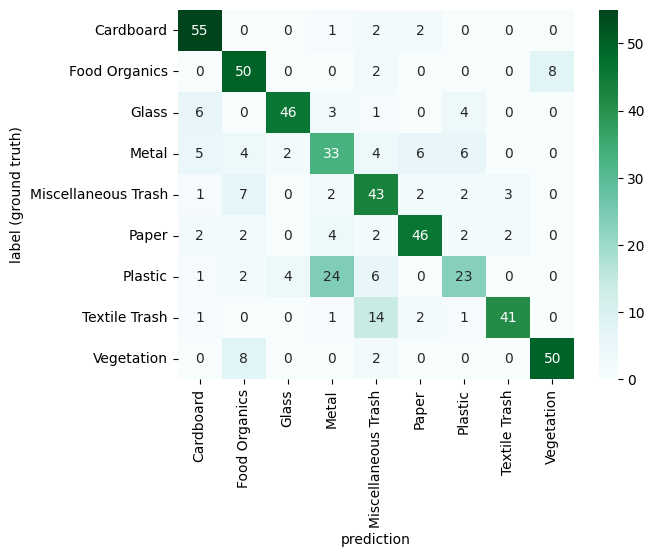

In [12]:
confusion_names = labels.copy()
print(confusion_names)
print(predicted)
arr = confusion_matrix(y_test.cpu().view(-1), predicted.cpu().view(-1))
df_cm = pd.DataFrame(arr, confusion_names, confusion_names)
plt.figure()
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

Index: [  315   333]
Label: [    5     5]
Class:  Paper Paper

Guess: [    7     7]
Class:  Textile Trash Textile Trash


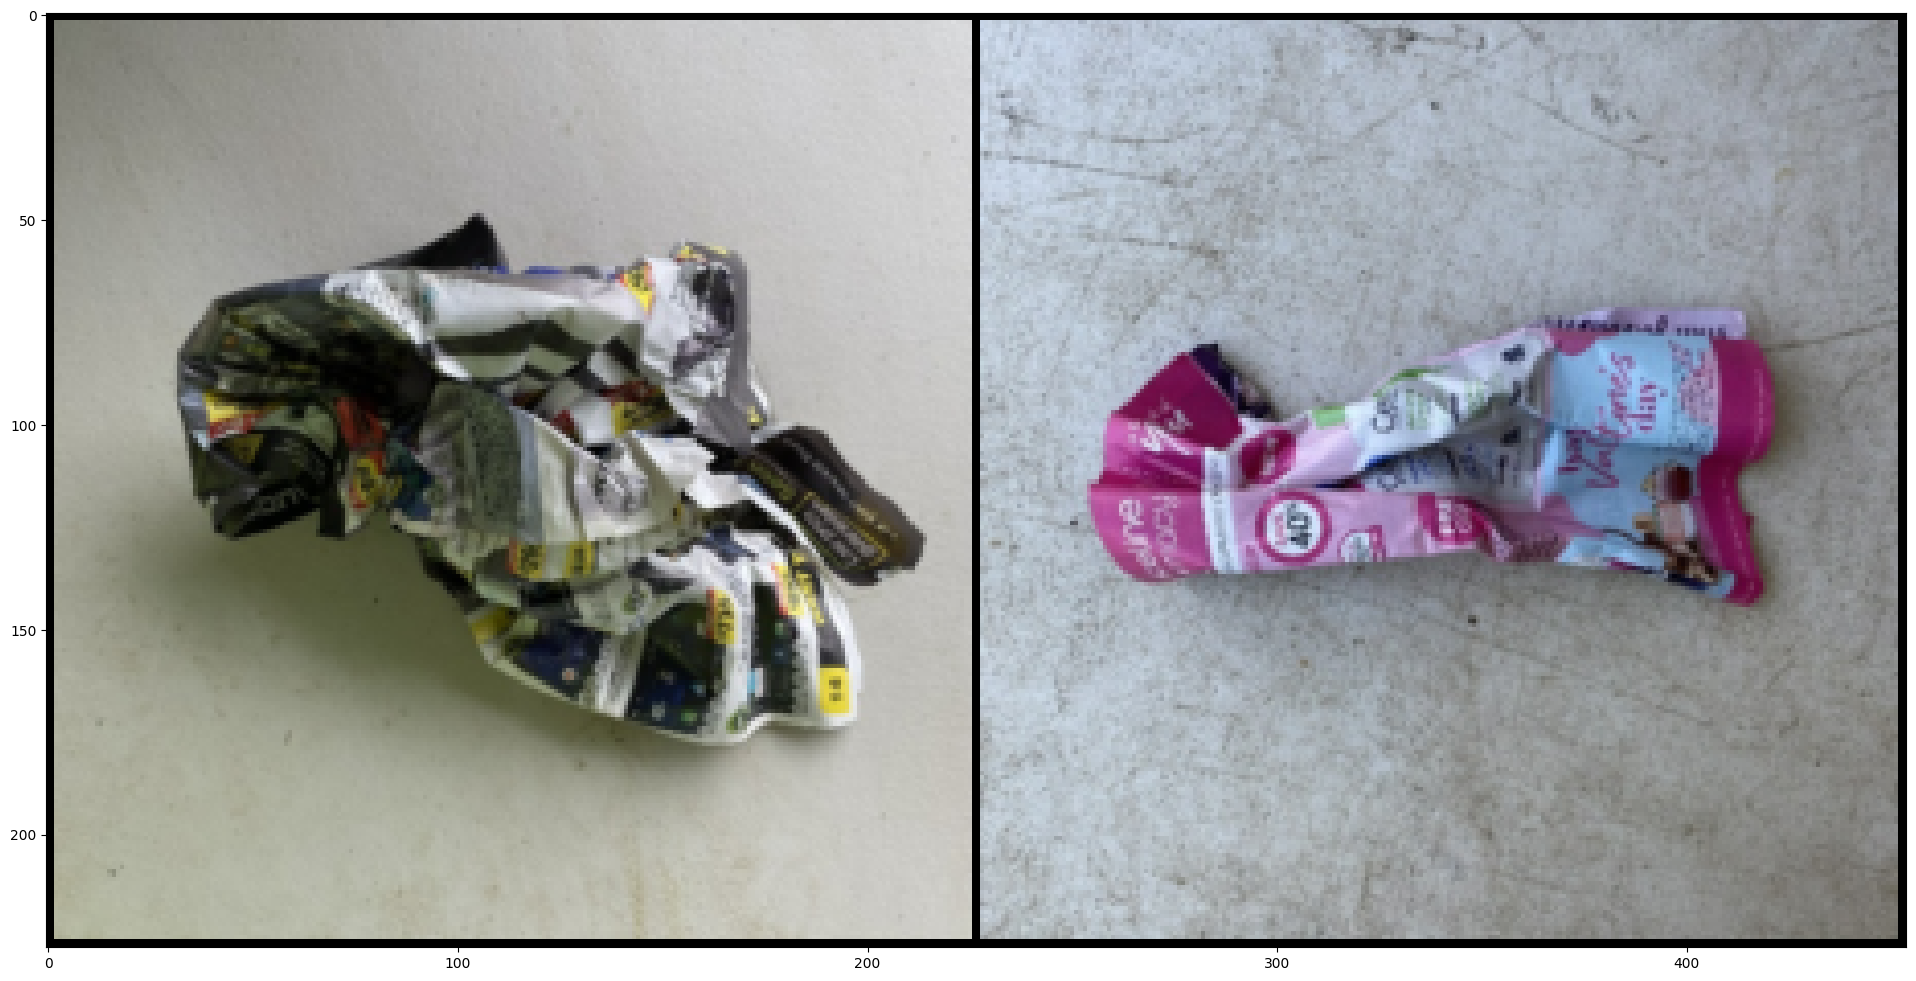

In [13]:
pred = labels.index('Textile Trash')
lbl = labels.index('Paper')
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] == pred and y_test[i] == lbl:
        misses = np.append(misses,i).astype('int64')
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))
r = 24
row = iter(np.array_split(misses,len(misses)//r+1))
nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([labels[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([labels[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(24,24))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))



Index: [  420   421   423   424   425   426   428   429   431   432   433   434
   435   436   437   439   441   442   443   444   446]
Label: [    7     7     7     7     7     7     7     7     7     7     7     7
     7     7     7     7     7     7     7     7     7]
Class:  Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash

Guess: [    7     7     7     7     7     7     7     7     7     7     7     7
     7     7     7     7     7     7     7     7     7]
Class:  Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash T

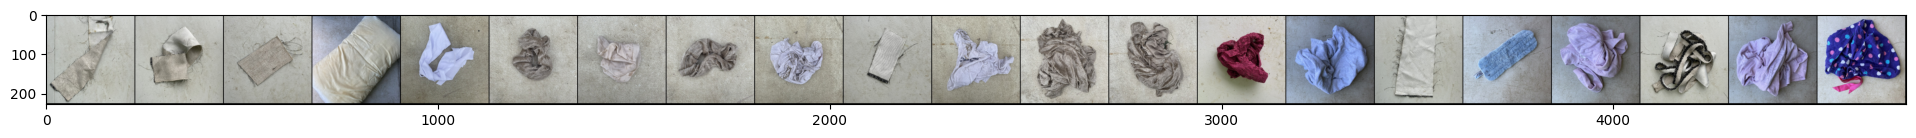

In [14]:
pred = labels.index('Textile Trash')
lbl = labels.index('Textile Trash')
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] == pred and y_test[i] == lbl:
        misses = np.append(misses,i).astype('int64')
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))
r = 24
row = iter(np.array_split(misses,len(misses)//r+1))
nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([labels[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([labels[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(24,24))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))